# Python Group 8 Assignment

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.tools as tls
import plotly.plotly as py
from sklearn.svm import SVR
from sklearn.base import clone
import plotly.graph_objs as go
import matplotlib.pyplot as plt
from scipy.special import boxcox1p
from sklearn.decomposition import PCA
from scipy.stats.mstats import winsorize
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.metrics import r2_score as metric_scorer
from sklearn.feature_selection import RFE, SelectFromModel
from scipy.stats import skew, boxcox_normmax, chi2_contingency
from sklearn.metrics import roc_auc_score, roc_curve, classification_report
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, KBinsDiscretizer, PowerTransformer
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, TimeSeriesSplit

tls.set_credentials_file(username='federicol', api_key='Xcyt2YoSMyqGKCjGYjMr')

import warnings
warnings.filterwarnings('ignore')

## Setting Key Values

In [2]:
SEED = 1
DATA_PATH = 'https://gist.githubusercontent.com/f-loguercio/f5c10c97fe9afe58f77cd102ca81719b/raw/99fb846b22abc8855de305c2159a57a77c9764cf/bikesharing_hourly.csv'
DATA_PATH2 = 'https://gist.githubusercontent.com/f-loguercio/14ac934fabcca41093a51efef335f8f2/raw/58e00b425c711ac1da2fb75f851f4fc9ce814cfa/bikesharing_daily.csv'
PREC_PATH = 'https://gist.githubusercontent.com/akoury/6fb1897e44aec81cced8843b920bad78/raw/b1161d2c8989d013d6812b224f028587a327c86d/precipitation.csv'
TARGET_VARIABLE = 'cnt'
SPLITS = 5
ESTIMATORS = 50
#For metric, import the required library as metric_scorer
METRIC = 'r2'

## Data Reading and Exploration
Here we read the data, print its first rows and describe its contents

In [50]:
def read_data(input_path):
    return pd.read_csv(input_path, parse_dates=[1])

data = read_data(DATA_PATH)
data_daily = read_data(DATA_PATH2)

data.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1

### Add Precipitation Data from the National Climatic Data Center

In [51]:
precipitation = read_data(PREC_PATH)
data = pd.merge(data, precipitation,  how='left', on=['dteday','hr'])
data.fillna(0, inplace=True)
data.head()

instant     dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1 2011-01-01       1   0     1   0        0        6           0   
1        2 2011-01-01       1   0     1   1        0        6           0   
2        3 2011-01-01       1   0     1   2        0        6           0   
3        4 2011-01-01       1   0     1   3        0        6           0   
4        5 2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  \
0           1  0.24  0.2879  0.81        0.0       3          13   16   
1           1  0.22  0.2727  0.80        0.0       8          32   40   
2           1  0.22  0.2727  0.80        0.0       5          27   32   
3           1  0.24  0.2879  0.75        0.0       3          10   13   
4           1  0.24  0.2879  0.75        0.0       0           1    1   

   precipitation  
0       0.020000  
1       0.003333  
2       0.010000  
3       0.007500  
4       0.007143

In [52]:
data.describe()

instant        season            yr          mnth            hr  \
count  17379.0000  17379.000000  17379.000000  17379.000000  17379.000000   
mean    8690.0000      2.501640      0.502561      6.537775     11.546752   
std     5017.0295      1.106918      0.500008      3.438776      6.914405   
min        1.0000      1.000000      0.000000      1.000000      0.000000   
25%     4345.5000      2.000000      0.000000      4.000000      6.000000   
50%     8690.0000      3.000000      1.000000      7.000000     12.000000   
75%    13034.5000      3.000000      1.000000     10.000000     18.000000   
max    17379.0000      4.000000      1.000000     12.000000     23.000000   

            holiday       weekday    workingday    weathersit          temp  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.028770      3.003683      0.682721      1.425283      0.496987   
std        0.167165      2.005771      0.465431      0.639357      0.192556   
min        0.000000      0.000000      0.000000      1.000000      0.020000   
25%        0.000000      1.000000      0.000000      1.000000      0.340000   
50%        0.000000      3.000000      1.000000      1.000000      0.500000   
75%        0.000000      5.000000      1.000000      2.000000      0.660000   
max        1.000000      6.000000      1.000000      4.000000      1.000000   

              atemp           hum     windspeed        casual    registered  \
count  17379.000000  17379.000000  17379.000000  17379.000000  17379.000000   
mean       0.475775      0.627229      0.190098     35.676218    153.786869   
std        0.171850      0.192930      0.122340     49.305030    151.357286   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.333300      0.480000      0.104500      4.000000     34.000000   
50%        0.484800      0.630000      0.194000     17.000000    115.000000   
75%        0.621200      0.780000      0.253700     48.000000    220.000000   
max        1.000000      1.000000      0.850700    367.000000    886.000000   

                cnt  precipitation  
count  17379.000000   17379.000000  
mean     189.463088       0.002928  
std      181.387599       0.018661  
min        1.000000       0.000000  
25%       40.000000       0.000000  
50%      142.000000       0.000000  
75%      281.000000       0.000000  
max      977.000000       0.580000

We review the data types for each column

In [53]:
data.dtypes

instant                   int64
dteday           datetime64[ns]
season                    int64
yr                        int64
mnth                      int64
hr                        int64
holiday                   int64
weekday                   int64
workingday                int64
weathersit                int64
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
casual                    int64
registered                int64
cnt                       int64
precipitation           float64
dtype: object

We check if there is any missing data

In [54]:
def missing_data(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data(data)

Total  Percent
precipitation      0      0.0
cnt                0      0.0
dteday             0      0.0
season             0      0.0
yr                 0      0.0
mnth               0      0.0
hr                 0      0.0
holiday            0      0.0
weekday            0      0.0
workingday         0      0.0
weathersit         0      0.0
temp               0      0.0
atemp              0      0.0
hum                0      0.0
windspeed          0      0.0
casual             0      0.0
registered         0      0.0
instant            0      0.0

We drop unnecessary columns

In [55]:
def drop_columns(df, cols):
    df.drop(df[cols], axis=1, inplace = True)
    return df

data = drop_columns(data, ['instant','casual'])
data.head()

dteday  season  yr  mnth  hr  holiday  weekday  workingday  weathersit  \
0 2011-01-01       1   0     1   0        0        6           0           1   
1 2011-01-01       1   0     1   1        0        6           0           1   
2 2011-01-01       1   0     1   2        0        6           0           1   
3 2011-01-01       1   0     1   3        0        6           0           1   
4 2011-01-01       1   0     1   4        0        6           0           1   

   temp   atemp   hum  windspeed  registered  cnt  precipitation  
0  0.24  0.2879  0.81        0.0          13   16       0.020000  
1  0.22  0.2727  0.80        0.0          32   40       0.003333  
2  0.22  0.2727  0.80        0.0          27   32       0.010000  
3  0.24  0.2879  0.75        0.0          10   13       0.007500  
4  0.24  0.2879  0.75        0.0           1    1       0.007143

## Converting Columns to their true categorical type
Now fixing the data types of numerical columns that are actually categorical

In [56]:
def convert_to_category(df, cols):
    for i in cols:
        df[i] = df[i].astype('category')
    return df

data = convert_to_category(data, data.iloc[:,1:9])

data.dtypes

dteday           datetime64[ns]
season                 category
yr                     category
mnth                   category
hr                     category
holiday                category
weekday                category
workingday             category
weathersit             category
temp                    float64
atemp                   float64
hum                     float64
windspeed               float64
registered                int64
cnt                       int64
precipitation           float64
dtype: object

We check if any value in the dataset is NA

## Adding Registered Customers Lag

In [10]:
#def add_lag(df, cols, lags):
#     new_cols = []
#     for col in cols:
#         for lag in lags:
#             new_col = df['registered'].shift(-lag).rename(str(col) + '_' + str(lag))
#             new_cols.append(new_col) 
#     df = pd.concat([df, new_cols], axis = 1)
#     return df

# data = add_lag(data, ['registered'], [1,24])
# holdout = add_lag(data, ['registered'], [1,24])

# registered_1 = data['registered'].shift(-1).rename("registered_1")
# registered_24 = data['registered'].shift(-24).rename("registered_24")
# data = pd.concat([data, registered_1, registered_24], axis = 1)

# registered_1 = holdout['registered'].shift(-1).rename("registered_1")
# registered_24 = holdout['registered'].shift(-24).rename("registered_24")
# holdout = pd.concat([holdout, registered_1, registered_24], axis = 1)

# registered_1 = data['registered'].shift(1)
# registered_1 = registered_1.rename("registered_1")
# registered_1[0] = registered_1[25]
# registered_24 = data['registered'].shift(24)
# registered_24[0:24] = data['registered'][0:24] - 0.1
# registered_24 = registered_24.rename("registered_24")

# data = pd.concat([data, registered_24], axis = 1)
# data.head()

## Creating Holdout Set for Final Validation

In [57]:
holdout = data[data['dteday'].isin(pd.date_range('2012-10-01','2012-12-31'))].copy()
data = data[data['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

# Exploratory Data Analysis

## Plotting the target variable

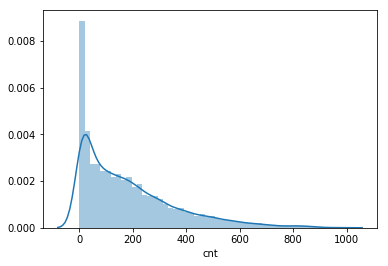

In [12]:
sns.distplot(data['cnt'])

### Time series evolution

Usage over time

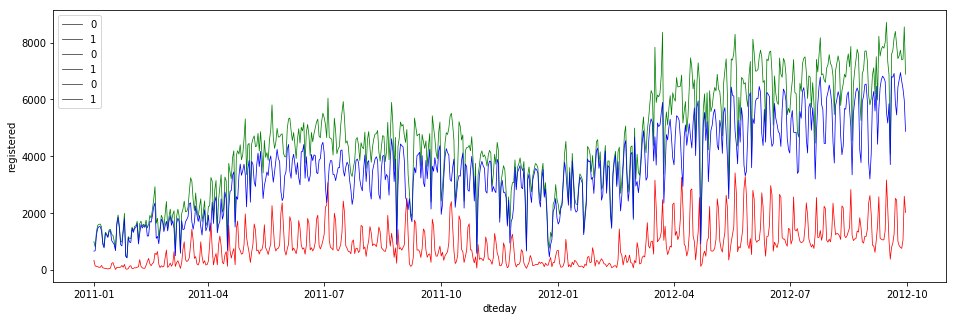

In [13]:
data_daily = data_daily[data_daily['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]

data_daily = convert_to_category(data_daily, data_daily.iloc[:,2:9])
data_daily.set_index('dteday')


plt.figure(figsize=(16, 5))
sns.lineplot(data = data_daily, x = 'dteday', y = 'cnt', color='green', size = 1)
sns.lineplot(data = data_daily, x = 'dteday', y = 'casual', color='r', size = 1)
sns.lineplot(data = data_daily, x = 'dteday', y = 'registered', color='blue', size = 1)

### Monthly averages

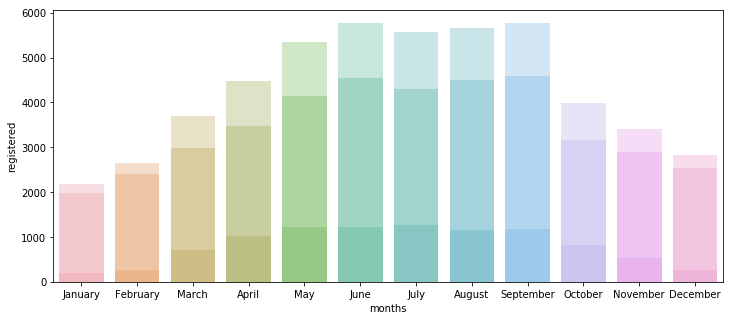

In [14]:
df_month = pd.DataFrame(data_daily.groupby("mnth")[["cnt", 'casual', 'registered']].mean()).reset_index()
months = pd.Series(["January","February","March","April","May","June","July","August","September","October","November","December"]).rename("months")
df_month = pd.concat([df_month, months], axis = 1)


plt.figure(figsize=(12, 5))
sns.barplot(data = df_month, x = "months", y = "cnt", alpha=.3)
sns.barplot(data = df_month, x = "months", y = "casual", alpha=.3)
sns.barplot(data = df_month, x = "months", y = "registered", alpha=.3)

No considerable differences in trends between casual and registered

### Weekly trend

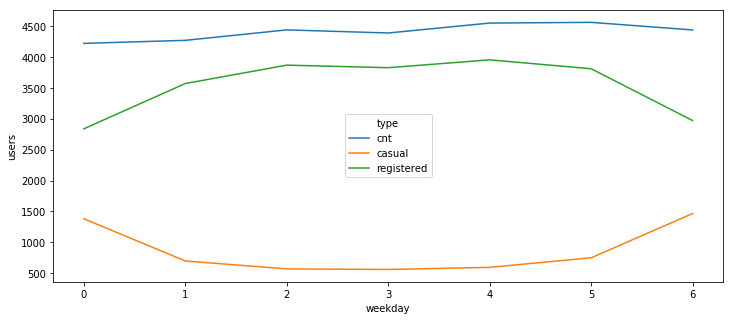

In [15]:
df_week = pd.DataFrame(data_daily.groupby("weekday")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_week = pd.melt(df_week, id_vars = ['weekday'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_week, x = "weekday", y = "users", hue = "type")

Casual and registered users follow exactly opposed trends throughout the week.

### Daily trend

By type of users

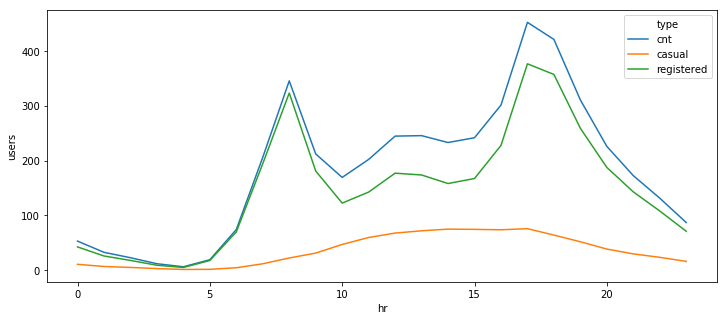

In [16]:
data_hourly = read_data(DATA_PATH)

#Leave out holdout-data:
data_hourly = data_hourly[data_hourly['dteday'].isin(pd.date_range('2011-01-01','2012-09-30'))]
data_hourly = convert_to_category(data_hourly, data_hourly.iloc[:,2:9])
data_hourly.set_index('dteday')


df_day = pd.DataFrame(data_hourly.groupby("hr")[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day = pd.melt(df_day, id_vars = ['hr'], value_vars = ['cnt', 'casual', 'registered'], var_name = 'type', value_name = 'users')

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day, x = "hr", y = "users", hue = "type")

By day of the week

In [17]:
# #sns.lineplot(data = data_hourly, x = "hr", y = "casual", hue = "weekday")
# df_day_by_day = pd.DataFrame(data_hourly.groupby(["hr", "weekday"])[["cnt", 'casual', 'registered']].mean()).reset_index()

# plt.figure(figsize=(12, 5))
# sns.lineplot(data = df_day_by_day, x = "hr", y = "casual", hue = "weekday")

In [18]:
# plt.figure(figsize=(12, 5))
# sns.lineplot(data = df_day_by_day, x = "hr", y = "registered", hue = "weekday")

### Temperature has larger effect on casual users

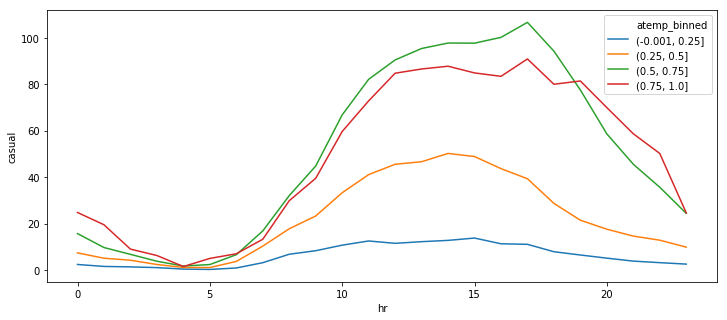

In [19]:
atemp_binned = pd.cut(x = data_hourly['atemp'], bins = 4).rename('atemp_binned')
data_hourly_binned = pd.concat([data_hourly, atemp_binned], axis = 1)

df_day_by_day_atemp = pd.DataFrame(data_hourly_binned.groupby(["hr", "atemp_binned"])[["cnt", 'casual', 'registered']].mean()).reset_index()
df_day_by_day_atemp.head()

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'casual', hue = 'atemp_binned')

### Than on registered users

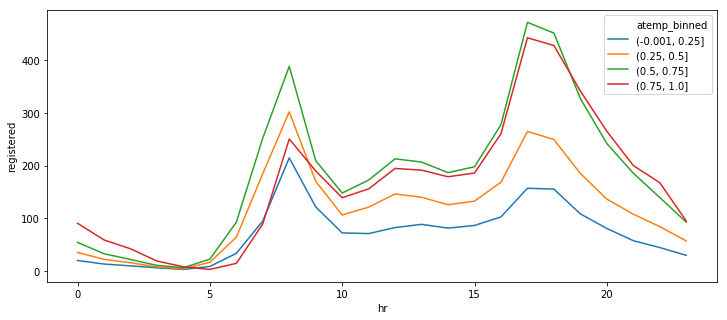

In [20]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_atemp, x = 'hr', y = 'registered', hue = 'atemp_binned')

### The weather situation does not appear to have a different effect on casual and registered users

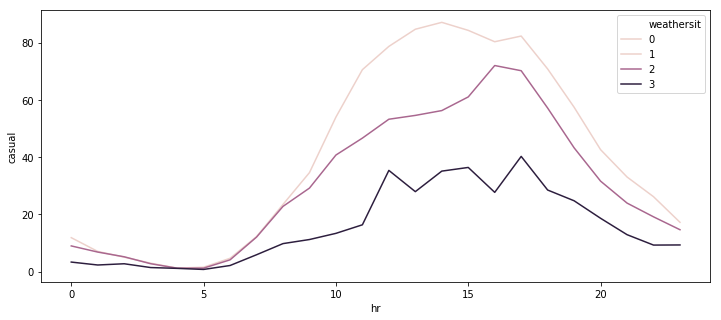

In [21]:
df_day_by_day_weathersit = pd.DataFrame(data_hourly_binned.groupby(["hr", "weathersit"])[["cnt", 'casual', 'registered']].mean()).reset_index()

# Remove weatersit 4, as it is full of NAs:
df_day_by_day_weathersit = df_day_by_day_weathersit[df_day_by_day_weathersit['weathersit'] != 4]
df_day_by_day_weathersit.head()

plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_weathersit, x = 'hr', y = 'casual', hue = 'weathersit')

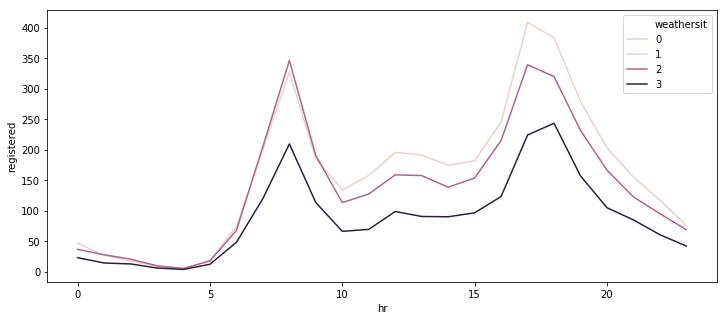

In [22]:
plt.figure(figsize=(12, 5))
sns.lineplot(data = df_day_by_day_weathersit, x = 'hr', y = 'registered', hue = 'weathersit')

### Does temperature affect usage differently on working days?

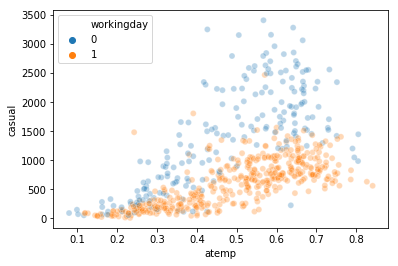

In [23]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'casual', hue = 'workingday', alpha = .3)

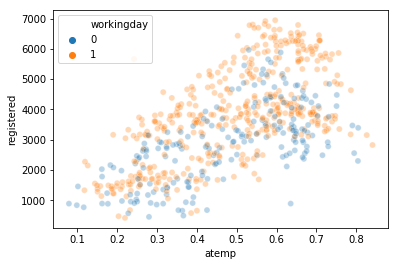

In [24]:
sns.scatterplot(data = data_daily, x = 'atemp', y = 'registered', hue = 'workingday', alpha = .3)

### Overall distribution of target variable

In [25]:
data_hist = [go.Histogram(x=data['cnt'])]

py.iplot(data_hist, filename='basic histogram')

In [26]:
trace = go.Scatter(
    x = data['atemp'],
    y = data['windspeed'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='windspeed'
    ),
    xaxis=go.layout.XAxis(
        title='temperature'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='basic-scatter')

In [27]:
trace = go.Scatter(
    x = data['hr'],
    y = data['hum'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='humidity'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_hr_hum')

In [28]:
trace = go.Scatter(
    x = data['hr'],
    y = data['cnt']-data['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='casual users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

In [29]:
trace = go.Scatter(
    x = data['hr'],
    y = data['registered'],
    mode = 'markers'
)

layout = go.Layout(
    autosize=False,
    width=400,
    height=400,
    yaxis=go.layout.YAxis(
        title='registered users'
    ),
    xaxis=go.layout.XAxis(
        title='hour'
    )
)

trace = [trace]

fig = go.Figure(data=trace, layout=layout)

py.iplot(fig, filename='scatter_casual_hr')

## Cross Validation
Now we will perform cross validation

In [30]:
def cv_evaluate(df, splits = 10, model = None, transformers = None, final = False, skipGrid = True):
    folds = TimeSeriesSplit(n_splits = splits)
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    train_size = int(len(df) * 0.85)
    X_train, X_validate, y_train, y_validate = X[0:train_size], X[train_size:len(df)], y[0:train_size], y[train_size:len(df)]
    if model is None:
        model = make_pipeline(LinearRegression())

    if transformers:
        model = make_pipeline(model)
        for ind,i in enumerate(transformers):
            model.steps.insert(ind,[str(ind+1),i])

#     if final:
#         if skipGrid:
#             model = make_pipeline(model)
#             for ind,i in enumerate(transformers):
#                 model.steps.insert(ind,[str(ind+1),i])
#             scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = folds)
#             model.fit(X_train, y_train)
#         else: 
#             #grid={'logisticregression__C':[0.01, 0.1, 1, 10], 'logisticregression__solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 'logisticregression__penalty':['l1','l2'], 'logisticregression__dual': [True, False], 'logisticregression__random_state': [SEED, SEED + 1, SEED + 2]}
#             #model = GridSearchCV(model, grid, scoring = METRIC, cv= folds, refit=True, return_train_score = False, error_score=0.0)
#             model.fit(X_train, y_train)
#             scores = model.cv_results_['mean_test_score']
#         sns.distplot(scores[scores > 0.0], hist = False, kde = True, kde_kws = {'shade': True, 'linewidth': 3})
#         plt.title('Distribution of ' + METRIC + ' scores while performing Grid Search')
#         plt.show()
#     else:
    scores = cross_val_score(model, X_train, y_train, scoring = METRIC, cv = folds)
    model.fit(X_train, y_train)

    pred = model.predict(X_validate)
    final_score = metric_scorer(y_validate, pred)
    
    return final_score, scores, model

## Extracting Day Variable

In [58]:
def extract_day(df):
    df['day'] = df['dteday'].dt.day
    df = convert_to_category(df, ['day'])
    df = drop_columns(df, ['dteday'])
    return df

data = extract_day(data)
holdout = extract_day(holdout)
data.head()

season yr mnth hr holiday weekday workingday weathersit  temp   atemp   hum  \
0      1  0    1  0       0       6          0          1  0.24  0.2879  0.81   
1      1  0    1  1       0       6          0          1  0.22  0.2727  0.80   
2      1  0    1  2       0       6          0          1  0.22  0.2727  0.80   
3      1  0    1  3       0       6          0          1  0.24  0.2879  0.75   
4      1  0    1  4       0       6          0          1  0.24  0.2879  0.75   

   windspeed  registered  cnt  precipitation day  
0        0.0          13   16       0.020000   1  
1        0.0          32   40       0.003333   1  
2        0.0          27   32       0.010000   1  
3        0.0          10   13       0.007500   1  
4        0.0           1    1       0.007143   1

## Data Correlation
Now we will look at correlation, both numerical and categorical and plot them

In [32]:
def numerical_correlated(df, threshold=0.9):
    corr_matrix = np.absolute(df.select_dtypes(include=[np.number]).corr(method='spearman')).abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr_matrix

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1), (rcorr-1)))

def categorical_correlated(df, threshold=0.9):
    columns = df.select_dtypes(include=['object', 'category']).columns.tolist()
    corr = pd.DataFrame(index=columns, columns=columns)
    for i in range(0, len(columns)):
        for j in range(i, len(columns)):
            if i == j:
                corr[columns[i]][columns[j]] = 1.0
            else:
                cell = cramers_v(df[columns[i]], df[columns[j]])
                corr[columns[i]][columns[j]] = cell
                corr[columns[j]][columns[i]] = cell
    corr.fillna(value=np.nan, inplace=True)
    upper = corr.where(
    np.triu(np.ones(corr.shape), k=1).astype(np.bool))
    return [column for column in upper.columns if any(abs(upper[column]) > threshold)], corr


def correlated(df, threshold=0.9):
    return (categorical_correlated(df, threshold), numerical_correlated(df, threshold))

correlated_cols = correlated(data, 0.7)

if(len(correlated_cols[0][0]) + len(correlated_cols[1][0]) > 0):
    print('The following columns are correlated: ' + str(correlated_cols[0][0] + correlated_cols[1][0]))
else:
    print('No correlated columns for the selected threshold')

The following columns are correlated: ['mnth', 'workingday', 'atemp', 'cnt']


Plot the categorical columns

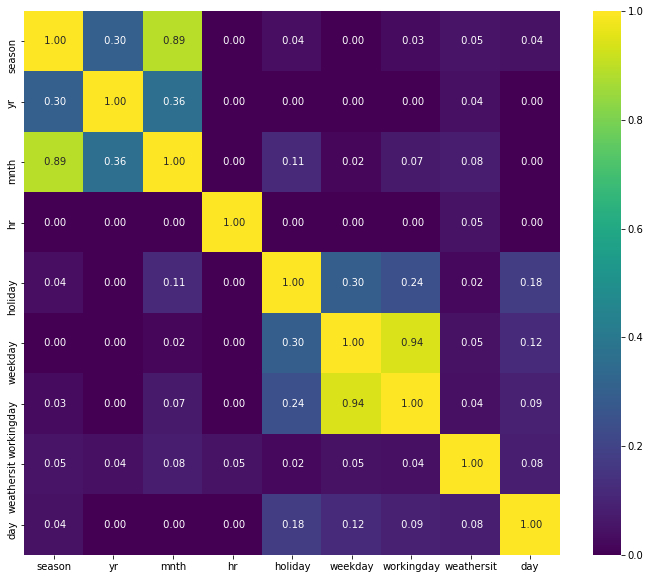

In [33]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[0][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

Plot the numerical columns

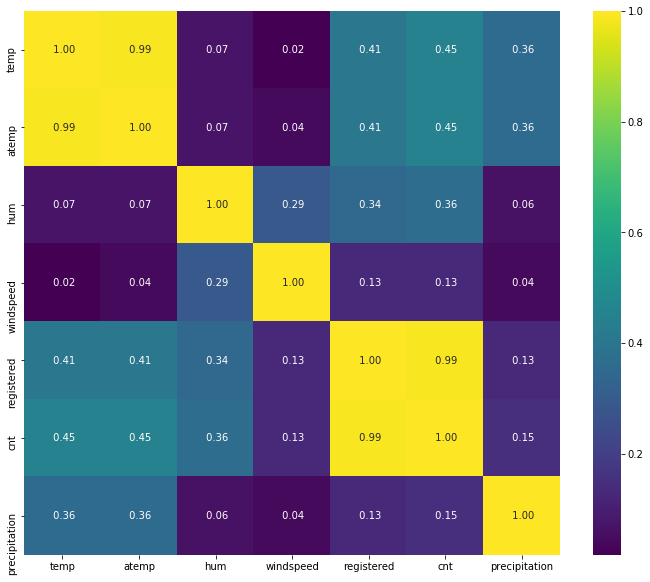

In [34]:
plt.figure(figsize=(12,10))
sns.heatmap(correlated_cols[1][1],cbar=True,fmt =' .2f', annot=True, cmap='viridis')

## Dropping Selected Correlated Columns

In [60]:
data = drop_columns(data, ['mnth', 'workingday', 'temp', 'registered'])
holdout = drop_columns(holdout, ['mnth', 'workingday', 'temp', 'registered'])
data.head()

season yr hr holiday weekday weathersit   atemp   hum  windspeed  cnt  \
0      1  0  0       0       6          1  0.2879  0.81        0.0   16   
1      1  0  1       0       6          1  0.2727  0.80        0.0   40   
2      1  0  2       0       6          1  0.2727  0.80        0.0   32   
3      1  0  3       0       6          1  0.2879  0.75        0.0   13   
4      1  0  4       0       6          1  0.2879  0.75        0.0    1   

   precipitation day  
0       0.020000   1  
1       0.003333   1  
2       0.010000   1  
3       0.007500   1  
4       0.007143   1

## Outlier Winsorizing
Now we will winsorize outliers

In [61]:
def winsorize_data(df, cols):
    df[cols.columns] = winsorize(df[cols.columns], limits = [0.01, 0.01])
    return df

data = winsorize_data(data, data.iloc[:,np.r_[:,6:9,10]])
holdout = winsorize_data(holdout, holdout.iloc[:,np.r_[:,6:9,10]])

data.describe()

atemp           hum     windspeed           cnt  precipitation
count  15211.000000  15211.000000  15211.000000  15211.000000   15211.000000
mean       0.489206      0.623925      0.191523    185.225232       0.003345
std        0.174757      0.193931      0.122334    177.918222       0.019912
min        0.000000      0.000000      0.000000      1.000000       0.000000
25%        0.333300      0.470000      0.104500     39.000000       0.000000
50%        0.500000      0.620000      0.194000    138.000000       0.000000
75%        0.621200      0.780000      0.253700    275.000000       0.000000
max        0.940000      0.940000      0.850700    977.000000       0.580000

## Fixing Data Skewness and Standardizing
Now we will fix skewness if present and standardize numerical features

In [62]:
pt = PowerTransformer(method='yeo-johnson', standardize = True).fit(data.iloc[:,np.r_[:,6:9,10]])
data.iloc[:,np.r_[:,6:9,10]] = pt.transform(data.iloc[:,np.r_[:,6:9,10]])
holdout.iloc[:,np.r_[:,6:9,10]] = pt.transform(holdout.iloc[:,np.r_[:,6:9,10]])
data.head()

season yr hr holiday weekday weathersit     atemp       hum  windspeed  cnt  \
0      1  0  0       0       6          1 -1.147905  0.961518  -1.781706   16   
1      1  0  1       0       6          1 -1.225622  0.907024  -1.781706   40   
2      1  0  2       0       6          1 -1.225622  0.907024  -1.781706   32   
3      1  0  3       0       6          1 -1.147905  0.636715  -1.781706   13   
4      1  0  4       0       6          1 -1.147905  0.636715  -1.781706    1   

   precipitation day  
0       3.975355   1  
1       2.390424   1  
2       3.760203   1  
3       3.515856   1  
4       3.463964   1

In [63]:
data.describe()

atemp           hum     windspeed           cnt  precipitation
count  1.521100e+04  1.521100e+04  1.521100e+04  15211.000000   1.521100e+04
mean  -1.386247e-14  4.242802e-16  2.482328e-17    185.225232   2.278743e-14
std    1.000033e+00  1.000033e+00  1.000033e+00    177.918222   1.000033e+00
min   -2.490369e+00 -2.944484e+00 -1.781706e+00      1.000000  -2.639621e-01
25%   -9.113109e-01 -8.081638e-01 -6.809794e-01     39.000000  -2.639621e-01
50%    1.419285e-02 -4.892937e-02  1.165379e-01    138.000000  -2.639621e-01
75%    7.423180e-01  7.984679e-01  5.885810e-01    275.000000  -2.639621e-01
max    2.874430e+00  1.682787e+00  3.706122e+00    977.000000   3.987906e+00

### One Hot Encoding
Hot encoding categorical columns

In [64]:
def one_hot_encode(df, cols):
    initialColumns = set(df)
    
    for i in cols:
        dummies = pd.get_dummies(df[i], prefix=i, drop_first = True)
        df = pd.concat([df, dummies], axis = 1)
        df = df.drop(i, axis = 1)
    
    df = convert_to_category(df, set(df) - initialColumns)
    return df

data = one_hot_encode(data, data.iloc[:,np.r_[:,0:4, 5,11]])
holdout = one_hot_encode(holdout, holdout.iloc[:,np.r_[:,0:4, 5,11]])

data.head()

weekday     atemp       hum  windspeed  cnt  precipitation season_2  \
0       6 -1.147905  0.961518  -1.781706   16       3.975355        0   
1       6 -1.225622  0.907024  -1.781706   40       2.390424        0   
2       6 -1.225622  0.907024  -1.781706   32       3.760203        0   
3       6 -1.147905  0.636715  -1.781706   13       3.515856        0   
4       6 -1.147905  0.636715  -1.781706    1       3.463964        0   

  season_3 season_4 yr_1  ... day_22 day_23 day_24 day_25 day_26 day_27  \
0        0        0    0  ...      0      0      0      0      0      0   
1        0        0    0  ...      0      0      0      0      0      0   
2        0        0    0  ...      0      0      0      0      0      0   
3        0        0    0  ...      0      0      0      0      0      0   
4        0        0    0  ...      0      0      0      0      0      0   

  day_28 day_29 day_30 day_31  
0      0      0      0      0  
1      0      0      0      0  
2      0      0      0      0  
3      0      0      0      0  
4      0      0      0      0  

[5 rows x 67 columns]

## Underrepresented Features
Now we will see underrepresented features

In [65]:
def under_represented_features(df, threshold = 0.9):
    under_rep = []
    for column in df:
        counts = df[column].value_counts()
        majority_freq = counts.iloc[0]
        if (majority_freq / len(df)) > threshold:
            under_rep.append(column)
    return under_rep

under_represented = under_represented_features(data.loc[:, data.columns != TARGET_VARIABLE])

if not under_represented:
    print('No underrepresented features')
else:
    print(str(under_represented) + ' are underrepresented')
#     data = drop_columns(data, data.columns)
    data.head()

['precipitation', 'hr_1', 'hr_2', 'hr_3', 'hr_4', 'hr_5', 'hr_6', 'hr_7', 'hr_8', 'hr_9', 'hr_10', 'hr_11', 'hr_12', 'hr_13', 'hr_14', 'hr_15', 'hr_16', 'hr_17', 'hr_18', 'hr_19', 'hr_20', 'hr_21', 'hr_22', 'hr_23', 'holiday_1', 'weathersit_3', 'weathersit_4', 'day_2', 'day_3', 'day_4', 'day_5', 'day_6', 'day_7', 'day_8', 'day_9', 'day_10', 'day_11', 'day_12', 'day_13', 'day_14', 'day_15', 'day_16', 'day_17', 'day_18', 'day_19', 'day_20', 'day_21', 'day_22', 'day_23', 'day_24', 'day_25', 'day_26', 'day_27', 'day_28', 'day_29', 'day_30', 'day_31'] are underrepresented


## Feature Selection
Now we will do feature selection to determine which features to keep

Feature ranking:


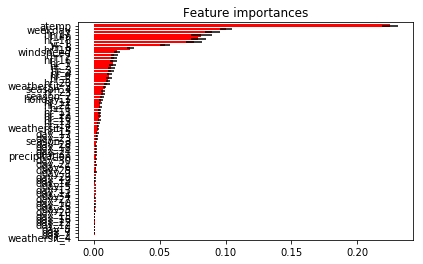

[34, 28, 13, 17, 12, 11, 10, 9, 24, 15, 3, 27, 16, 8, 26, 2, 25, 0, 1, 4]

In [66]:
def feature_importance(df, ratio = 0.01, plot = False):
    forest = RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)
    acc, scores, forest = cv_evaluate(df, model = forest)
    importances = forest.feature_importances_
    std = np.std([tree.feature_importances_ for tree in forest.estimators_],axis=0)
    indices = np.argsort(importances)
    
    if plot:
        X = df.loc[:, df.columns != TARGET_VARIABLE]
        print("Feature ranking:")
        plt.figure()
        plt.title("Feature importances")
        plt.barh(range(X.shape[1]), importances[indices],color="r", xerr=std[indices], align="center")
        plt.yticks(range(X.shape[1]), [list(df.loc[:, df.columns != TARGET_VARIABLE])[i] for i in indices])
        plt.ylim([-1, X.shape[1]])
        plt.show()
    
    
    keep = [x for x in indices if importances[x] > ratio]
    target = df.columns.get_loc(TARGET_VARIABLE)
    if target not in keep:
        keep.append(target)
        
    return keep

feature_importance(data, plot = True)

## Principal Component Analysis (PCA)
We will plot PCA component variance

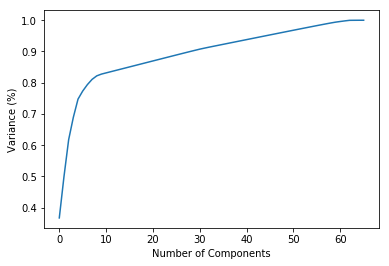

4

In [67]:
def plot_pca_components(df, variance = 0.9):
    X = df.loc[:, df.columns != TARGET_VARIABLE]
    y = df.loc[:, TARGET_VARIABLE]
    pca = PCA()
    X = pca.fit_transform(X)
    pca = PCA().fit(X)

    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)')
    plt.show()
    
    count = 0
    
    for ind, i in enumerate(np.cumsum(pca.explained_variance_ratio_)):
        if count < variance:
            count += i
        else:
            return ind + 1
        
plot_pca_components(data)

## Pipeline
The feature engineering pipeline will decide which functions to keep and which not to based on if they improve the score

In [68]:
def feature_engineering_pipeline(df, models, transformers):
    selected_transformers = []
    
    base_score, base_scores, base_model = cv_evaluate(df, splits = SPLITS)
    top_model = models[0]
    best_score = 0
    all_scores  = pd.DataFrame(columns = ['Model', 'Function', 'CV Score', 'Holdout Score', 'Difference', 'Outcome'])
    all_scores = all_scores.append({'Model': 'base linear_regression', 'Function':'base_score','CV Score': '{:.2f} +/- {:.02}'.format(np.mean(base_scores[base_scores > 0.0]),np.std(base_scores[base_scores > 0.0])),'Holdout Score': base_score, 'Difference': 0, 'Outcome': 'Base'}, ignore_index=True)
    
    for model in models:
        top_score = base_score
        for transformer in transformers:
            engineered_data = df.copy()
            outcome = 'Rejected'
            
            try:
                transformer_score, scores, cv_model = cv_evaluate(engineered_data, model = model[1], transformers = [transformer[1]], splits = SPLITS)
                difference = (transformer_score - top_score)

                if difference > 0:
                    selected_transformers.append((model[0], transformer[1]))
                    top_score = transformer_score
                    outcome = 'Accepted'
                    
                    if transformer_score > best_score:
                        best_score = transformer_score
                        top_model = model

                score = {'Model': model[0], 'Function':transformer[0],'CV Score': '{:.2f} +/- {:.02}'.format(np.mean(scores[scores > 0.0]),np.std(scores[scores > 0.0])),'Holdout Score': transformer_score, 'Difference': difference, 'Outcome': outcome}

            except: 
                score = {'Model': model[0], 'Function':transformer[0],'CV Score': '0','Holdout Score': 0, 'Difference': 0, 'Outcome': 'Error'}
        
            all_scores = all_scores.append(score, ignore_index=True)

    return top_model, [t[1] for t in selected_transformers if t[0] == top_model[0]], all_scores

## Running the Pipeline
Here we will run the pipeline

In [70]:
models = [
    ('linear_regression', LinearRegression()),
    ('random_forest', RandomForestRegressor(n_estimators=ESTIMATORS, random_state = SEED)),
    ('adaboost', AdaBoostRegressor()),
    ('gradient_boosting', GradientBoostingRegressor(random_state=SEED)),
    ('support_vector', SVR(kernel='rbf', C=1e3, gamma=0.1))
]

transformers = [
    ('rfe', RFE(LinearRegression())),
    ('feature_selection', SelectFromModel(LinearRegression())),
    ('binning', KBinsDiscretizer(n_bins=5, encode='onehot')),
    ('polynomial', PolynomialFeatures(degree=2, include_bias=False)),
    ('pca', PCA(.95))
]

top_we_model, final_we_transformers, all_we_scores = feature_engineering_pipeline(data.loc[data['weekday'].isin([0,6])], models, transformers)

if len(final_we_transformers) > 0:
    we_holdout_score, we_scores, we_model = cv_evaluate(data, model = clone(top_we_model[1]), splits = SPLITS, transformers = final_we_transformers)
else:
    we_holdout_score, we_scores, we_model = cv_evaluate(data, model = clone(top_we_model[1]), splits = SPLITS)
score = {'Model': top_we_model[0], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(we_scores[we_scores > 0.0]),np.std(we_scores[we_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(we_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_we_scores = all_we_scores.append(score, ignore_index=True)



top_wd_model, final_wd_transformers, all_wd_scores = feature_engineering_pipeline(data.loc[~data['weekday'].isin([0,6])], models, transformers)

if len(final_wd_transformers) > 0:
    wd_holdout_score, wd_scores, wd_model = cv_evaluate(data, model = clone(top_wd_model[1]), splits = SPLITS, transformers = final_wd_transformers)
else:
    wd_holdout_score, wd_scores, wd_model = cv_evaluate(data, model = clone(top_wd_model[1]), splits = SPLITS)
    
score = {'Model': top_wd_model[0], 'Function': 'cross_evaluate','CV Score': '{:.3f} +/- {:.02}'.format(np.mean(wd_scores[wd_scores > 0.0]),np.std(wd_scores[wd_scores > 0.0])), 'Holdout Score': "{0:.3f}".format(wd_holdout_score), 'Difference': 0, 'Outcome': 'Final Cross Validation'}
all_wd_scores = all_wd_scores.append(score, ignore_index=True)

## Scores
Here you can see all of the scores

In [45]:
all_we_scores

Model           Function        CV Score Holdout Score  \
0  base linear_regression         base_score    0.72 +/- 0.0      0.734976   
1           random_forest                rfe   0.52 +/- 0.21      0.816248   
2           random_forest  feature_selection    0.79 +/- 0.0       0.82884   
3           random_forest         polynomial   0.46 +/- 0.13      0.613995   
4           random_forest     cross_evaluate  0.371 +/- 0.12         0.290   

  Difference                 Outcome  
0          0                    Base  
1   0.081272                Accepted  
2  0.0125925                Accepted  
3  -0.214845                Rejected  
4          0  Final Cross Validation

In [46]:
all_wd_scores

Model           Function        CV Score Holdout Score  \
0  base linear_regression         base_score    0.75 +/- 0.0      0.744315   
1           random_forest                rfe   0.66 +/- 0.09        0.8713   
2           random_forest  feature_selection    0.70 +/- 0.0      0.709008   
3           random_forest         polynomial   0.64 +/- 0.17      0.876272   
4           random_forest     cross_evaluate  0.409 +/- 0.16         0.665   

   Difference                 Outcome  
0           0                    Base  
1    0.126985                Accepted  
2   -0.162292                Rejected  
3  0.00497187                Accepted  
4           0  Final Cross Validation

In [71]:
#This should be uncommented when you run GridSearch
#final_model = model.best_estimator_
#model.best_params_

#This should be removed after
final_we_model = we_model
final_wd_model = wd_model

# Final Score
This is the final score of the model

In [72]:
def predict(df, holdout_df, model):
    X_train = df.loc[:, df.columns != TARGET_VARIABLE]
    y_train = df.loc[:, TARGET_VARIABLE]
    model.fit(X_train, y_train)
    
    X = holdout_df.loc[:, holdout_df.columns != TARGET_VARIABLE]
    y = holdout_df.loc[:, TARGET_VARIABLE]
    pred = pd.DataFrame(model.predict(X), columns = ['pred'])
    return pred.set_index(y.index)

y_we_preds = predict(data.loc[data['weekday'].isin([0,6])], holdout.loc[holdout['weekday'].isin([0,6])], final_we_model)
y_wd_preds = predict(data.loc[~data['weekday'].isin([0,6])], holdout.loc[~holdout['weekday'].isin([0,6])], final_wd_model)

final_holdout = pd.merge(holdout, y_we_preds,how = 'left',left_index = True, right_index = True, suffixes=('',''))
final_holdout.loc[~holdout['weekday'].isin([0,6]), 'pred'] = y_wd_preds

y = holdout.loc[:, TARGET_VARIABLE]
pred = final_holdout['pred']
score = metric_scorer(y, pred)
print(score)

0.8116603372728769


## Plot of Predictions

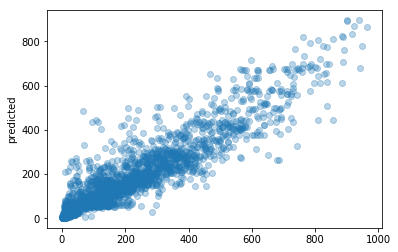

In [73]:
plt.scatter(y, pred, alpha=0.3)
plt.ylabel('predicted')
plt.show()

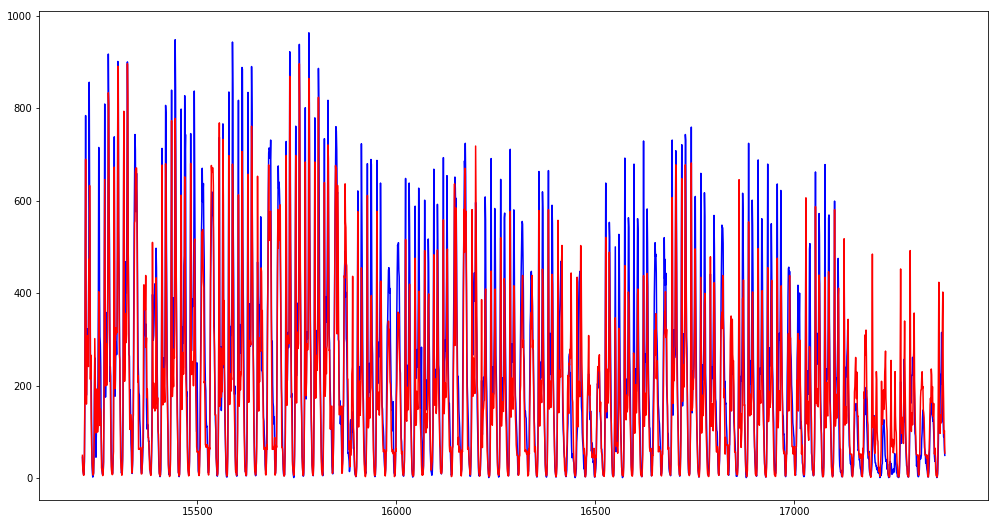

In [84]:
plt.figure(figsize=(17, 9))
sns.lineplot(data = y, color='blue')
sns.lineplot(data = pred, color='red')

# To Do
* Fix Graphs
* Fix GridSearch
* Winsorize holdout?
* Use specific model for RFE, FI?
* Try not dropping some columns (correlated for example)
* Try dropping Atemp instead of temp